In [1]:
import nmm
import jax.numpy as jnp
import numpy as np
from qutip import Qobj

In [2]:
bath=nmm.OverdampedBath(coupling=0.05,cutoff=5,T=1)

In [3]:
t=np.linspace(0,20,100)

In [4]:
import contextlib
import time

In [5]:
@contextlib.contextmanager
def timer(label):
    """ Simple utility for timing functions:

        with timer("name"):
            ... code to time ...
    """
    start = time.time()
    yield
    end = time.time()
    print(f"{label}: {end - start}")

In [6]:
sp=Qobj(np.array([[0,0],[1,0]]))
sm=Qobj(np.array([[0,1],[0,0]]))
sz=Qobj(np.array([[1,0],[0,-1]]))
sx=sm+sp
rho0=Qobj(np.array([[1,1],[1,1]]))*0.5

In [7]:
import nmm.redfield


In [8]:
cc=nmm.cumulant.csolve(Hsys=sx*0.5 + sz*0.25,baths=[bath],t=t,Qs=[sz],eps=1e-2,cython=False)
cc2=nmm.cumulant.csolve(Hsys=sx*0.5+ sz*0.25,baths=[bath],t=t,Qs=[sz],cython=False,matsubara=500)

In [9]:
import matplotlib.pyplot as plt
import itertools

In [10]:
with timer("Cumulant solution"):
    ans=cc.evolution(rho0)

Computing Exponential of Generators . . . .: 100%|██████████| 100/100 [00:00<00:00, 1571.90it/s]

Cumulant solution: 21.82430338859558


In [11]:
with timer("Cumulant solution"):
    ans2=cc2.evolution(rho0)

Computing Exponential of Generators . . . .: 100%|██████████| 100/100 [00:00<00:00, 6256.61it/s]

Cumulant solution: 0.7626895904541016


In [12]:
import qutip as qt

In [13]:
t2=np.linspace(0,10,2)


In [14]:
red=nmm.redfield.redfield(Hsys=qt.sigmax()*0.5 + qt.sigmaz()*0.25,baths=[bath,bath],t=t,Qs=[qt.sigmaz()],eps=2,matsubara=False)
red2=nmm.redfield.redfield(Hsys=qt.sigmax()*0.5+ qt.sigmaz()*0.25,baths=[bath,bath],t=t,Qs=[qt.sigmaz()],matsubara=500)


In [15]:
rho02 = qt.Qobj(np.array([[1,1],[1,1]]))*0.5

In [16]:
with timer("Redfield Matsubara solution"):
    ansr=red2.evolution(rho02)

Started interpolation


ValueError: operands could not be broadcast together with shapes (100,) (500,) 

In [ ]:
def population(states,i,j):
    return [l.data[i,j] for l in states]
def population2(states,i,j):
    return [l[i,j] for l in states]

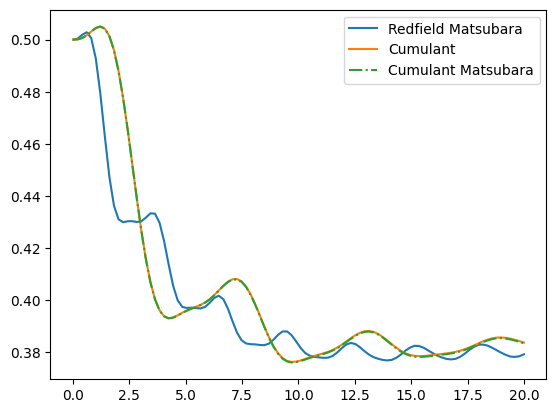

In [ ]:
cohcum=population2(ans,0,0)
cohcum2=population2(ans2,0,0)
states=population2(ansr,0,0)
plt.plot(cc.t,np.abs(states),label="Redfield Matsubara")
plt.plot(cc.t,np.abs(cohcum),label="Cumulant")
plt.plot(cc.t,np.abs(cohcum2),"-.",label="Cumulant Matsubara")
plt.legend()
plt.show()

In [ ]:
from qutip.solver.heom import *

In [ ]:
bath = DrudeLorentzBath(qt.sigmaz(), cc2.baths[0].coupling*np.pi, cc2.baths[0].cutoff, cc2.baths[0].T,15, tag='bath 1')
b1delta, b1term = bath.terminator()


/home/mcditoos/anaconda3/envs/qutip-dev/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mcditoos/anaconda3/envs/qutip-dev/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


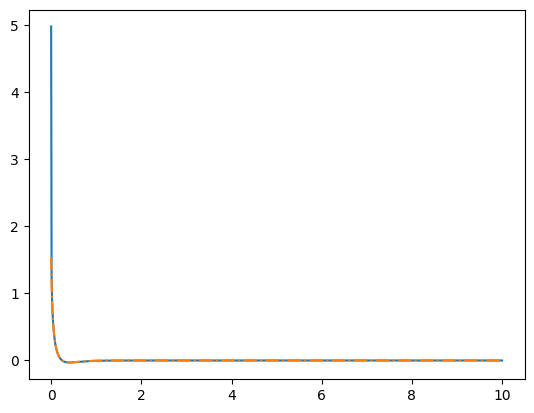

In [ ]:
times=np.linspace(0,10,1000)
plt.plot(times,bath.correlation_function(times))
plt.plot(times,bath.correlation_function_approx(times),'-.')

In [ ]:
solver = HEOMSolver(qt.liouvillian(red2.Hsys) +b1term,
                    [bath], max_depth=6)
result = solver.run(rho02, red2.t)

10.1%. Run time:  57.20s. Est. time left: 00:00:08:29
20.2%. Run time: 154.02s. Est. time left: 00:00:10:08
30.3%. Run time: 305.47s. Est. time left: 00:00:11:42
40.4%. Run time: 412.13s. Est. time left: 00:00:10:07
50.5%. Run time: 464.47s. Est. time left: 00:00:07:35
60.6%. Run time: 518.95s. Est. time left: 00:00:05:37
70.7%. Run time: 571.87s. Est. time left: 00:00:03:56
80.8%. Run time: 624.43s. Est. time left: 00:00:02:28
90.9%. Run time: 679.76s. Est. time left: 00:00:01:07
100.0%. Run time: 790.20s. Est. time left: 00:00:00:00
Total run time: 790.21s


In [ ]:
def rotation(data, t, diagonal=True):
    rotated = [
        (1j * red2.Hsys * t[i]).expm()
        * data[i]
        * (-1j * red2.Hsys * t[i]).expm()
        for i in range(len(t))
    ]
    return rotated

result_fa=rotation(result.states,result.times)

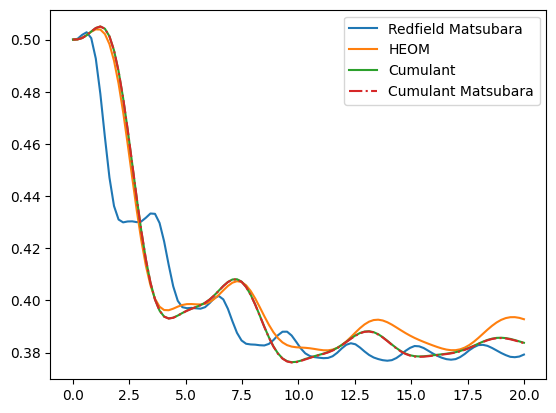

In [ ]:
cohcum=population(ans,0,0)
cohcum2=population(ans2,0,0)
states=population2(ansr,0,0)
states2=population2(result.states,0,0)
states3=population2(result_fa,0,0)
plt.plot(cc.t,np.abs(states),label="Redfield Matsubara")
plt.plot(cc.t,np.abs(states3),label="HEOM")
plt.plot(cc.t,np.abs(cohcum),label="Cumulant")
plt.plot(cc.t,np.abs(cohcum2),"-.",label="Cumulant Matsubara")
plt.legend()
plt.show()

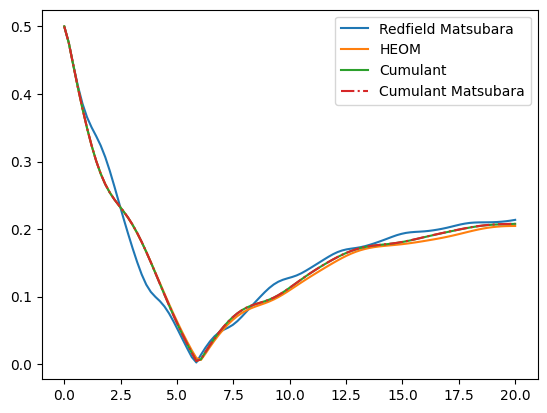

In [ ]:
cohcum=population(ans,0,1)
cohcum2=population(ans2,0,1)
states=population2(ansr,0,1)
states2=population2(result.states,0,1)
states3=population2(result_fa,0,1)
plt.plot(cc.t,np.abs(states),label="Redfield Matsubara")
plt.plot(cc.t,np.abs(states3),label="HEOM")
plt.plot(cc.t,np.abs(cohcum),label="Cumulant")
plt.plot(cc.t,np.abs(cohcum2),"-.",label="Cumulant Matsubara")
plt.legend()
plt.show()